# 3. Linear Models for Regression

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
%matplotlib inline

from prml.features import GaussianFeatures, PolynomialFeatures, SigmoidalFeatures
from prml.linear import (
    BayesianRegressor,
    EmpiricalBayesRegressor,
    LinearRegressor,
    RidgeRegressor
)

np.random.seed(1234)

In [2]:
def create_toy_data(func, sample_size, std, domain=[0, 1]):
    x = np.linspace(domain[0], domain[1], sample_size)
    np.random.shuffle(x)
    t = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, t

## 3.1 Linear Basis Function Models

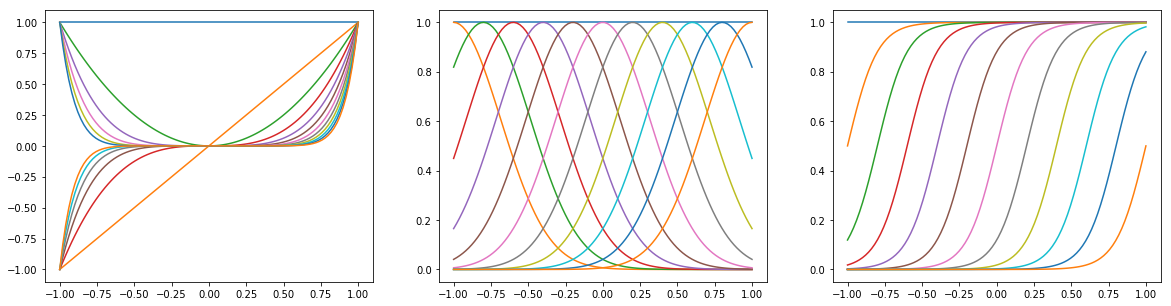

In [3]:
x = np.linspace(-1, 1, 100)
X_polynomial = PolynomialFeatures(11).transform(x[:, None])
X_gaussian = GaussianFeatures(np.linspace(-1, 1, 11), 0.1).transform(x)
X_sigmoidal = SigmoidalFeatures(np.linspace(-1, 1, 11), 10).transform(x)

plt.figure(figsize=(20, 5))
for i, X in enumerate([X_polynomial, X_gaussian, X_sigmoidal]):
    plt.subplot(1, 3, i + 1)
    for j in range(12):
        plt.plot(x, X[:, j])

### 3.1.1 Maximum likelihood and least squares

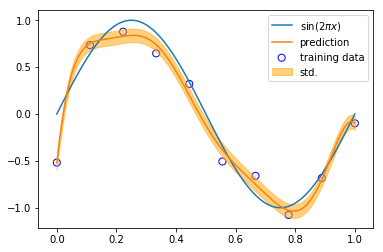

In [4]:
def sinusoidal(x):
    return np.sin(2 * np.pi * x)

x_train, y_train = create_toy_data(sinusoidal, 10, 0.25)
x_test = np.linspace(0, 1, 100)
y_test = sinusoidal(x_test)

# select one of the three features below
# feature = PolynomialFeatures(8)
feature = GaussianFeatures(np.linspace(0, 1, 8), 0.1)
# feature = SigmoidalFeatures(np.linspace(0, 1, 8), 10)

X_train = feature.transform(x_train)
X_test = feature.transform(x_test)
model = LinearRegressor()
model.fit(X_train, y_train)
y, y_std = model.predict(X_test, return_std=True)

plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test, y_test, label="$\sin(2\pi x)$")
plt.plot(x_test, y, label="prediction")
plt.fill_between(
    x_test, y - y_std, y + y_std,
    color="orange", alpha=0.5, label="std.")
plt.legend()
plt.show()

### 3.1.4 Regularized least squares

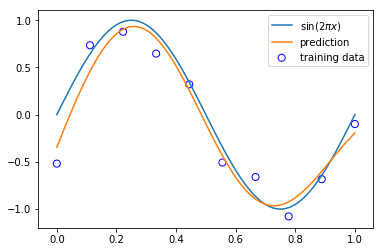

In [5]:
model = RidgeRegressor(alpha=1e-3)
model.fit(X_train, y_train)
y = model.predict(X_test)

plt.scatter(x_train, y_train, facecolor="none", edgecolor="b", s=50, label="training data")
plt.plot(x_test, y_test, label="$\sin(2\pi x)$")
plt.plot(x_test, y, label="prediction")
plt.legend()
plt.show()

## 3.2 The Bias-Variance Decomposition

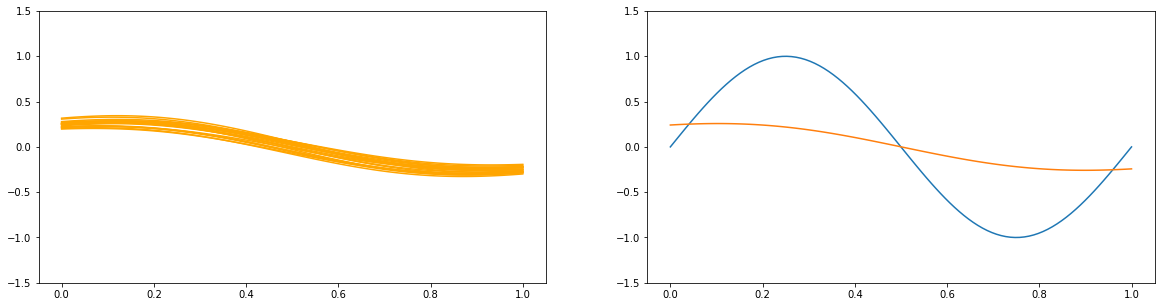

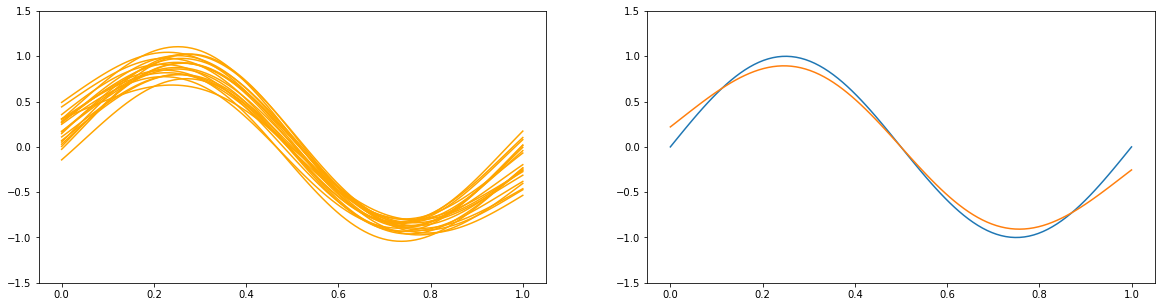

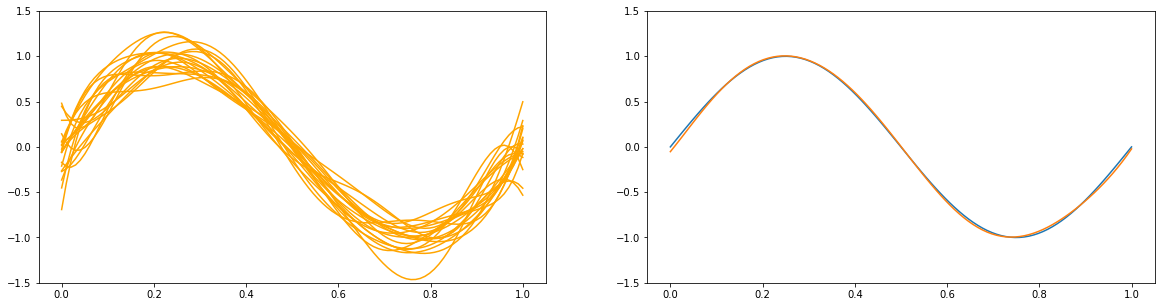

In [14]:
# feature = PolynomialFeatures(24)
feature = GaussianFeatures(np.linspace(0, 1, 24), 0.1)
# feature = SigmoidalFeatures(np.linspace(0, 1, 24), 10)

for a in [1e2, 1e-1, 1e-9]:
    y_list = []
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 2, 1)
    for i in range(100):
        x_train, y_train = create_toy_data(sinusoidal, 25, 0.3)
        X_train = feature.transform(x_train)
        X_test = feature.transform(x_test)
        model = RidgeRegressor(alpha=a)
        model.fit(X_train, y_train)
        y = model.predict(X_test)
        y_list.append(y)
        if i < 20:
            plt.plot(x_test, y, c="orange")
    plt.ylim(-1.5, 1.5)
    
    plt.subplot(1, 2, 2)
    plt.plot(x_test, y_test)
    plt.plot(x_test, np.asarray(y_list).mean(axis=0))
    plt.ylim(-1.5, 1.5)
    plt.show()

## 3.3 Bayesian Linear Regression

### 3.3.1 Parameter distribution

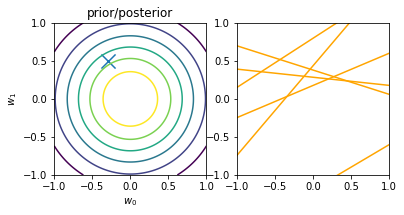

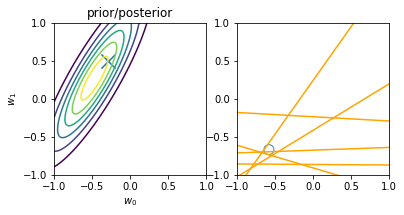

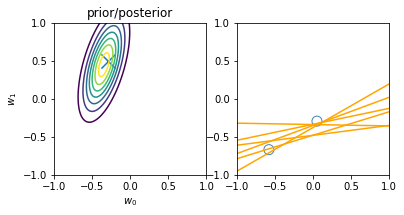

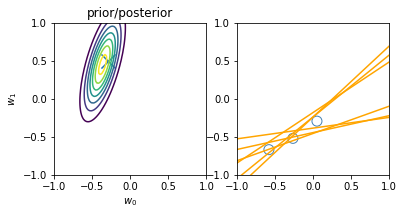

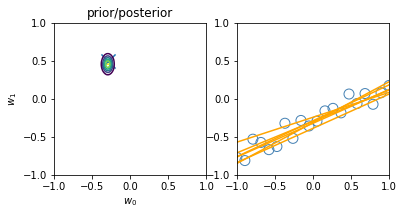

In [22]:
def linear(x):
    return -0.3 + 0.5 * x


x_train, y_train = create_toy_data(linear, 20, 0.1, [-1, 1])
x = np.linspace(-1, 1, 100)
w0, w1 = np.meshgrid(
    np.linspace(-1, 1, 100),
    np.linspace(-1, 1, 100))
w = np.array([w0, w1]).transpose(1, 2, 0)

feature = PolynomialFeatures(degree=1)
X_train = feature.transform(x_train)
X = feature.transform(x)
model = BayesianRegressor(alpha=2., beta=25.)

for begin, end in [[0, 0], [0, 1], [1, 2], [2, 3], [3, 20]]:
    model.fit(X_train[begin: end], y_train[begin: end])
    plt.subplot(1, 2, 1)
    plt.scatter(-0.3, 0.5, s=200, marker="x")
    plt.contour(w0, w1, multivariate_normal.pdf(w, mean=model.w_mean, cov=model.w_cov))
    plt.gca().set_aspect('equal')
    plt.xlabel("$w_0$")
    plt.ylabel("$w_1$")
    plt.title("prior/posterior")

    plt.subplot(1, 2, 2)
    plt.scatter(x_train[:end], y_train[:end], s=100, facecolor="none", edgecolor="steelblue", lw=1)
    plt.plot(x, model.predict(X, sample_size=6), c="orange")
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

### 3.3.2 Predictive distribution

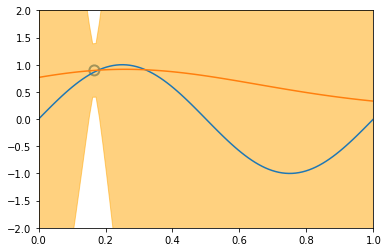

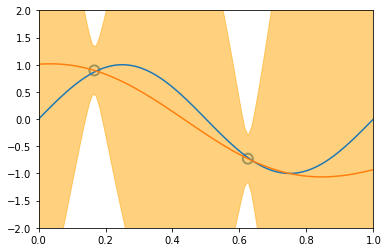

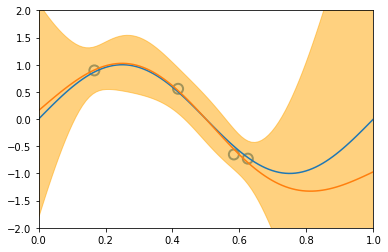

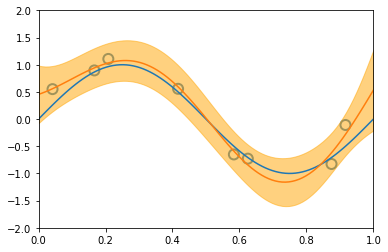

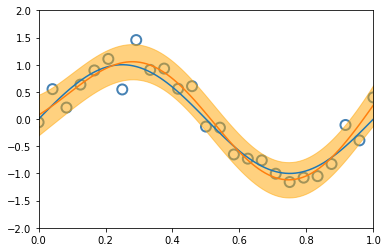

In [38]:
x_train, y_train = create_toy_data(sinusoidal, 25, 0.3)
x_test = np.linspace(0, 1, 100)
y_test = sinusoidal(x_test)

feature = GaussianFeatures(np.linspace(0, 1, 9), 0.1)
X_train = feature.transform(x_train)
X_test = feature.transform(x_test)

model = BayesianRegressor(alpha=5e-3, beta=11.1)

for begin, end in [[0, 1], [1, 2], [2, 4], [4, 8], [8, 25]]:
    model.fit(X_train[begin: end], y_train[begin: end])
    y, y_std = model.predict(X_test, return_std=True)
    plt.scatter(x_train[:end], y_train[:end], s=100, facecolor="none", edgecolor="steelblue", lw=2)
    plt.plot(x_test, y_test)
    plt.plot(x_test, y)
    plt.fill_between(x_test, y - y_std, y + y_std, color="orange", alpha=0.5)
    plt.xlim(0, 1)
    plt.ylim(-2, 2)
    plt.show()

## 3.5 The Evidence Approximation

0.006419685699727986 0.011467480214396268


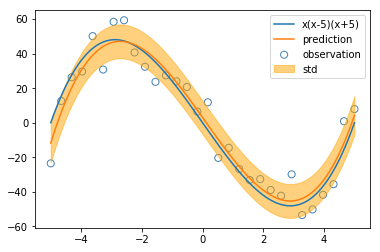

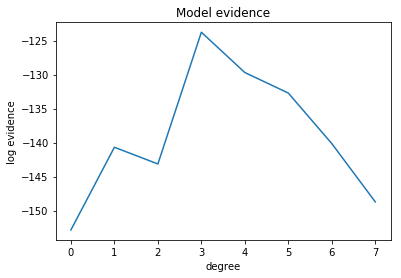

In [36]:
def cubic(x):
    return x * (x - 5) * (x + 5)

x_train, y_train = create_toy_data(cubic, 30, 10, [-5, 5])
x_test = np.linspace(-5, 5, 100)
evidences = []
models = []
for i in range(8):
    feature = PolynomialFeatures(degree=i)
    X_train = feature.transform(x_train)
    model = EmpiricalBayesRegressor(alpha=100., beta=100.)
    model.fit(X_train, y_train, max_iter=100)
    evidences.append(model.log_evidence(X_train, y_train))
    models.append(model)

degree = np.nanargmax(evidences)
regression = models[degree]
print(regression.alpha, regression.beta)

X_test = PolynomialFeatures(degree=int(degree)).transform(x_test)
y, y_std = regression.predict(X_test, return_std=True)

plt.scatter(x_train, y_train, s=50, facecolor="none", edgecolor="steelblue", label="observation")
plt.plot(x_test, cubic(x_test), label="x(x-5)(x+5)")
plt.plot(x_test, y, label="prediction")
plt.fill_between(x_test, y - y_std, y + y_std, alpha=0.5, label="std", color="orange")
plt.legend()
plt.show()

plt.plot(evidences)
plt.title("Model evidence")
plt.xlabel("degree")
plt.ylabel("log evidence")
plt.show()